In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor

LOAD DATASET

In [2]:
# Load dataset
df = pd.read_csv("../dataset/carbon_emission_final_engineered.csv")
print("Original shape:", df.shape)


Original shape: (2109, 27)


DROP COLUMNS

In [3]:
drop_cols = ['co2_per_km', 'co2_per_litre', 'efficiency_score', 'high_emitter', 'low_efficiency', 'co2_tier']
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

FEATURES AND TARGET 

In [4]:
 #Define features and target
features = [
    'distance_in_km_per_route', 'vehicle_age_in_years', 'load_factor',
    'no_of_stop', 'average_speed_in_km_per_hr',
    'adjusted_fuel_efficiency_in_km_litre', 'adjusted_energy_kwh_per_km',
    'fuel_per_km', 'total_energy_kwh', 'speed_per_stop', 'load_utilization',
    'vehicle_type', 'fuel_type', 'traffic_condition', 'engine_norm_type',
    'logistics_partner', 'mode'
]
target = 'c02_emission_kg'

X = df[features]
y = df[target]

PREPROCESSING

In [5]:
# Preprocessing
categorical = ['vehicle_type', 'fuel_type', 'traffic_condition', 'engine_norm_type', 'logistics_partner', 'mode']
numerical = [col for col in X.columns if col not in categorical]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical)
])

APPLYING XGBOOST REGRESSOR

In [6]:
# XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", xgb_model)
])

TRANING AND TESTING DATA

In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Train model
pipeline.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


PERFORMANCE METRICS

In [9]:
# Predictions and evaluation
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nXGBoost Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


XGBoost Performance:
MAE: 13.25
RMSE: 42.45
R² Score: 0.9816


ACTUAL VS PREDICTED COMPARISION

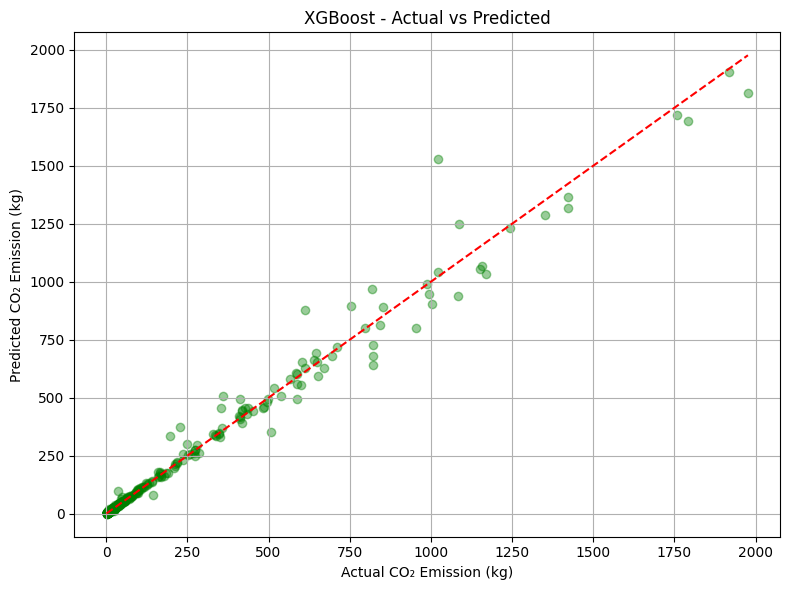

In [10]:
# Plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual CO₂ Emission (kg)")
plt.ylabel("Predicted CO₂ Emission (kg)")
plt.title("XGBoost - Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

FEATURE IMPORTANCE

In [11]:
# Feature importance
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
encoded_cat_features = ohe.get_feature_names_out(categorical)
all_features = numerical + list(encoded_cat_features)

importances = pipeline.named_steps['model'].feature_importances_

importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


C:\Users\acer\AppData\Local\Temp\ipykernel_8588\2112431146.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df[:15], x='Importance', y='Feature', palette='viridis')


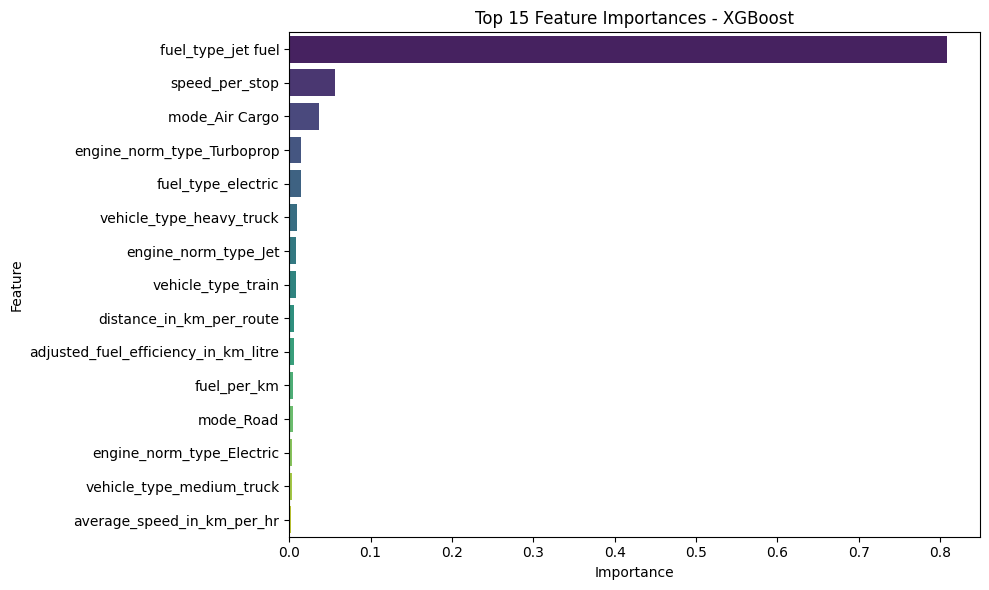

In [12]:
# Plot top 15
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df[:15], x='Importance', y='Feature', palette='viridis')
plt.title("Top 15 Feature Importances - XGBoost")
plt.tight_layout()
plt.show()

In [13]:
import joblib
joblib.dump(pipeline,"xgboost_pipeline.pkl")

['xgboost_pipeline.pkl']